<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM/LSTM_Al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 144 (delta 69), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (144/144), 119.43 KiB | 5.19 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 14 10:41:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Al'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 7.9MB/s 
     |████████████████████████████████| 102kB 13.0MB/s 
     |████████████████████████████████| 143kB 54.2MB/s 
     |████████████████████████████████| 174kB 52.9MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'input_size': {
            'values': [25, 50, 100]
        },
        'hidden_size': {
            'values': [25, 50, 100]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh']
        }
    }
}

In [13]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 50,
        'hidden_size': 50,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture
    model = Sequential()

    # input layer
    model.add(LSTM(units=config.input_size, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # second model layer with dropout
    model.add(LSTM(units=config.hidden_size, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # third model layer with dropout
    model.add(LSTM(units=config.hidden_size, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # fourth model layer with dropout
    model.add(LSTM(units=config.hidden_size, activation=config.activation))
    model.add(Dropout(config.dropout))
    # final layer with one output
    model.add(Dense(units=1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: j2ariuyw
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM/sweeps/j2ariuyw


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: hq5kjyv0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
16/16 [==============================] - 24s 139ms/step - loss: 0.1002 - mean_squared_error: 0.1002 - mean_absolute_error: 0.2563 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1030
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1151 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1367
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0896 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1157
Epoch 4/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0776 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0948
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0083 - mean_square

epoch,99
loss,0.00331
mean_squared_error,0.00331
mean_absolute_error,0.04502
val_loss,0.01025
val_mean_squared_error,0.01025
val_mean_absolute_error,0.06989
_runtime,58
_timestamp,1626259374
_step,99
best_val_loss,0.01025


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▅▅▅▅▅▅▄▃▄▃▃▃▃▄▂▃▃▃▂▂▂▂▅▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val_mean_squared_error,▇█▆▅▅▅▅▅▅▄▃▄▃▃▃▃▄▂▃▃▃▂▂▂▂▅▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val_mean_absolute_error,▆█▅▄▄▄▄▄▅▃▂▄▁▃▂▃▄▂▃▃▃▂▂▂▂▆▂▂▃▃▃▂▂▂▃▂▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: p8ry2xvy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 8s 224ms/step - loss: 0.1709 - mean_squared_error: 0.1709 - mean_absolute_error: 0.3282 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1561
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1564 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1115
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1192 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.0872
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0940 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0794
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0126 - mean_squared_error: 0.

epoch,99
loss,0.00179
mean_squared_error,0.00179
mean_absolute_error,0.03289
val_loss,0.00476
val_mean_squared_error,0.00476
val_mean_absolute_error,0.04809
_runtime,28
_timestamp,1626259410
_step,99
best_val_loss,0.00467


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▃▃▃▂▃▃▂▄▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: u9q55pm7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 9s 259ms/step - loss: 0.1923 - mean_squared_error: 0.1923 - mean_absolute_error: 0.3499 - val_loss: 0.0661 - val_mean_squared_error: 0.0661 - val_mean_absolute_error: 0.1986
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0831 - mean_squared_error: 0.0831 - mean_absolute_error: 0.2334 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1781
Epoch 3/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1421 - val_loss: 0.0700 - val_mean_squared_error: 0.0700 - val_mean_absolute_error: 0.2280
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - mean_absolute_error: 0.1999 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1142
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0252 - mean_squared_error: 0.0252 

epoch,49
loss,0.00424
mean_squared_error,0.00424
mean_absolute_error,0.05087
val_loss,0.00977
val_mean_squared_error,0.00977
val_mean_absolute_error,0.07536
_runtime,24
_timestamp,1626259443
_step,49
best_val_loss,0.00816


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▄▃▂▁▁▁▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅█▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅█▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▆█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▃▂▂▂▁▁▁▁▁▂▂▁▁▁▂
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: k23bmozq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 8s 257ms/step - loss: 0.2276 - mean_squared_error: 0.2276 - mean_absolute_error: 0.3668 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1299
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1568 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1175
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.1102 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.0978
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0743 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1018
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0080 - mean_squared_error: 0.0080 

epoch,49
loss,0.00322
mean_squared_error,0.00322
mean_absolute_error,0.0446
val_loss,0.0085
val_mean_squared_error,0.0085
val_mean_absolute_error,0.06317
_runtime,21
_timestamp,1626259479
_step,49
best_val_loss,0.00847


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▃▃▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▃▃▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▇▅▅▃▂▃▂▃▂▂▃▂▄▃▂▂▂▃▂▁▃▂▂▂▂▂▃▂▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: c4vxjbtr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 8s 65ms/step - loss: 0.0896 - mean_squared_error: 0.0896 - mean_absolute_error: 0.2375 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1032
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.1071 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1049
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0840 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.0936
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0794 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0998
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0089 - mean_squared_

epoch,99
loss,0.003
mean_squared_error,0.003
mean_absolute_error,0.04187
val_loss,0.00909
val_mean_squared_error,0.00909
val_mean_absolute_error,0.06852
_runtime,58
_timestamp,1626259554
_step,99
best_val_loss,0.00909


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇█▆▇▅▆▅▆▄▅▄▄▄▄▃▄▅▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁
val_mean_squared_error,█▇▇█▆▇▅▆▅▆▄▅▄▄▄▄▃▄▅▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁
val_mean_absolute_error,▇▆▇█▆▇▄▆▅▅▃▅▂▃▃▃▂▄▅▃▁▃▃▃▄▃▂▂▂▃▃▂▂▂▁▂▂▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gav4o9lk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 9s 122ms/step - loss: 0.0928 - mean_squared_error: 0.0928 - mean_absolute_error: 0.2328 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0993
Epoch 2/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1048 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1008
Epoch 3/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1118 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0910
Epoch 4/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0885 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1329
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0146 - mean_squared_erro

epoch,49
loss,0.00394
mean_squared_error,0.00394
mean_absolute_error,0.04796
val_loss,0.0055
val_mean_squared_error,0.0055
val_mean_absolute_error,0.05242
_runtime,30
_timestamp,1626259592
_step,49
best_val_loss,0.0055


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▇▅█▅▄▄▅▄▄▅▄▄▄▄▄▄▃▄▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁
val_mean_squared_error,▅▇▅█▅▄▄▅▄▄▅▄▄▄▄▄▄▃▄▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁
val_mean_absolute_error,▅▅▄█▃▃▃▅▃▃▅▅▄▄▅▃▄▂▅▃▂▃▂▄▃▂▁▂▂▂▁▃▂▁▁▁▂▂▂▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: evv2j1zp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 8s 151ms/step - loss: 0.1060 - mean_squared_error: 0.1060 - mean_absolute_error: 0.2578 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1150
Epoch 2/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1138 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0891
Epoch 3/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0777 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0783
Epoch 4/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0702 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0761
Epoch 5/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0076 - mean_squared

epoch,131
loss,0.00166
mean_squared_error,0.00166
mean_absolute_error,0.03068
val_loss,0.00233
val_mean_squared_error,0.00233
val_mean_absolute_error,0.03243
_runtime,49
_timestamp,1626259650
_step,131
best_val_loss,0.0023


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▇▇▅▆▆▄▆▄▄▄▄▄▃▃▄▂▂▂▂▂▂▂▂▃▁▁▁▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2q7yhnfx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 8s 237ms/step - loss: 0.1833 - mean_squared_error: 0.1833 - mean_absolute_error: 0.3584 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1538
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0398 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1668 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1106
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0266 - mean_squared_error: 0.0266 - mean_absolute_error: 0.1244 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1059
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - mean_absolute_error: 0.1137 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1351
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0165 - mean_squared_error: 0.0165 

epoch,49
loss,0.00737
mean_squared_error,0.00737
mean_absolute_error,0.06653
val_loss,0.01402
val_mean_squared_error,0.01402
val_mean_absolute_error,0.07814
_runtime,20
_timestamp,1626259678
_step,49
best_val_loss,0.01377


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▆▄▃▃▃▃▃▃▂▂▂▃▃▂▃▃▂▂▂▂▂▁▁▁▂▂▂▂▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▄▃▆▄▃▃▃▃▃▃▂▂▂▃▃▂▃▃▂▂▂▂▂▁▁▁▂▂▂▂▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▄▄▆▄▂▃▃▃▃▃▂▂▂▃▃▂▃▃▃▂▂▂▂▁▁▂▂▂▃▂▂▁▁▂▂▂▂▂▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jv9s2iyl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 9s 70ms/step - loss: 0.1060 - mean_squared_error: 0.1060 - mean_absolute_error: 0.2545 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1030
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0909 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1094
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0845 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0874
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0882 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0861
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0115 - mean_squared_

epoch,99
loss,0.00301
mean_squared_error,0.00301
mean_absolute_error,0.04207
val_loss,0.00735
val_mean_squared_error,0.00735
val_mean_absolute_error,0.06011
_runtime,72
_timestamp,1626259758
_step,99
best_val_loss,0.00699


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▆▆█▅▅▅▅▄▄▅▄▄▄▄▃▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁
val_mean_squared_error,█▇▇▇▆▆█▅▅▅▅▄▄▅▄▄▄▄▃▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁
val_mean_absolute_error,▇▅▆▇▅▆█▄▄▅▄▃▃▅▃▃▃▄▂▅▅▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zzjxpu2p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 8s 128ms/step - loss: 0.0877 - mean_squared_error: 0.0877 - mean_absolute_error: 0.2309 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0846
Epoch 2/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0866 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0835
Epoch 3/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0728 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1035
Epoch 4/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0684 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1038
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0085 - mean_squared

epoch,92
loss,0.00154
mean_squared_error,0.00154
mean_absolute_error,0.03013
val_loss,0.00231
val_mean_squared_error,0.00231
val_mean_absolute_error,0.03212
_runtime,41
_timestamp,1626259807
_step,92
best_val_loss,0.00226


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▅▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▄▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gs5l1urc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 7s 242ms/step - loss: 0.2318 - mean_squared_error: 0.2318 - mean_absolute_error: 0.4159 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1352
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0649 - mean_squared_error: 0.0649 - mean_absolute_error: 0.2061 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1421
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0469 - mean_squared_error: 0.0469 - mean_absolute_error: 0.1773 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.0963
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0480 - mean_squared_error: 0.0480 - mean_absolute_error: 0.1751 - val_loss: 0.0350 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1313
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0348 - mean_squared_error: 0.0348 

epoch,49
loss,0.00424
mean_squared_error,0.00424
mean_absolute_error,0.04992
val_loss,0.00653
val_mean_squared_error,0.00653
val_mean_absolute_error,0.05829
_runtime,21
_timestamp,1626259837
_step,49
best_val_loss,0.00486


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▇▄▆█▄▃▅▅▃▆▃▂▆▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁
val_mean_squared_error,▆▇▄▆█▄▃▅▅▃▆▃▂▆▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁
val_mean_absolute_error,▇▇▄▆█▅▃▇▇▄▇▂▃▆▃▃▂▂▂▃▃▂▂▂▃▃▂▃▃▃▁▃▁▂▂▃▃▁▁▂
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: fuxp11g0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 8s 121ms/step - loss: 0.1697 - mean_squared_error: 0.1697 - mean_absolute_error: 0.3471 - val_loss: 0.0426 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1841
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.1560 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1046
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1188 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1033
Epoch 4/100
16/16 [==============================] - 1s 35ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0951 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.0989
Epoch 5/100
16/16 [==============================] - 0s 27ms/step - loss: 0.0126 - mean_squared

epoch,62
loss,0.00626
mean_squared_error,0.00626
mean_absolute_error,0.06104
val_loss,0.01375
val_mean_squared_error,0.01375
val_mean_absolute_error,0.08256
_runtime,32
_timestamp,1626259888
_step,62
best_val_loss,0.01328


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▃▂▂▂▂▂▂▂▂▃▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▃▂▂▂▂▂▂▂▂▃▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▃▃▂▂▃▂▂▃▁▁▂▁▂▁▁▁▂▁▂▁▁▂▁▂▁▁▂▂▁▁▂▁▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: mheniek9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 7s 226ms/step - loss: 0.2208 - mean_squared_error: 0.2208 - mean_absolute_error: 0.3847 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1428
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0726 - mean_squared_error: 0.0726 - mean_absolute_error: 0.2174 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1557
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0364 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1524 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.0991
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - mean_absolute_error: 0.1306 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1617
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0239 - mean_squared_error: 0.0239 

epoch,49
loss,0.00584
mean_squared_error,0.00584
mean_absolute_error,0.06215
val_loss,0.00377
val_mean_squared_error,0.00377
val_mean_absolute_error,0.04121
_runtime,21
_timestamp,1626259917
_step,49
best_val_loss,0.00377


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▃▂▂▂▂▁▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁
val_loss,▇▆▃▆█▄▄▃▅▃▄▃▃▂▃▄▃▂▄▂▄▂▃▂▂▃▁▂▁▂▁▁▁▁▂▁▁▂▁▁
val_mean_squared_error,▇▆▃▆█▄▄▃▅▃▄▃▃▂▃▄▃▂▄▂▄▂▃▂▂▃▁▂▁▂▁▁▁▁▂▁▁▂▁▁
val_mean_absolute_error,▇█▄██▄▅▃▇▅▆▄▃▃▃▇▅▃▅▄▆▃▄▂▂▄▂▂▂▂▂▁▂▁▄▁▂▃▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8jbjdafu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 8s 70ms/step - loss: 1.0850 - mean_squared_error: 1.0850 - mean_absolute_error: 0.6180 - val_loss: 0.0836 - val_mean_squared_error: 0.0836 - val_mean_absolute_error: 0.2542
Epoch 2/50
31/31 [==============================] - 0s 15ms/step - loss: 0.4328 - mean_squared_error: 0.4328 - mean_absolute_error: 0.4173 - val_loss: 0.0493 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1664
Epoch 3/50
31/31 [==============================] - 0s 16ms/step - loss: 0.1039 - mean_squared_error: 0.1039 - mean_absolute_error: 0.2555 - val_loss: 0.0448 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1830
Epoch 4/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0747 - mean_squared_error: 0.0747 - mean_absolute_error: 0.2273 - val_loss: 0.2213 - val_mean_squared_error: 0.2213 - val_mean_absolute_error: 0.3786
Epoch 5/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0987 - mean_squared_error

epoch,49
loss,0.00495
mean_squared_error,0.00495
mean_absolute_error,0.05299
val_loss,0.00672
val_mean_squared_error,0.00672
val_mean_absolute_error,0.05896
_runtime,38
_timestamp,1626259965
_step,49
best_val_loss,0.00625


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▄▃▃▃▂▃▃▃▂▃▃▄▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▂▂█▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▂▂█▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅▃▄█▃▄▃▄▃▃▃▃▃▃▃▂▂▂▃▂▃▂▂▁▁▁▂▁▁▂▁▂▂▁▁▁▁▁▂▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rej9xz37 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 8s 68ms/step - loss: 0.0613 - mean_squared_error: 0.0613 - mean_absolute_error: 0.1778 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1261
Epoch 2/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0858 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0961
Epoch 3/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0816 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0895
Epoch 4/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0751 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0932
Epoch 5/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0098 - mean_squared_error

epoch,49
loss,0.00262
mean_squared_error,0.00262
mean_absolute_error,0.03988
val_loss,0.00675
val_mean_squared_error,0.00675
val_mean_absolute_error,0.06083
_runtime,37
_timestamp,1626260025
_step,49
best_val_loss,0.00651


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▅▆▇▄▄▅▅▃▄▄▃▃▄▄▄▃▃▂▂▂▃▂▂▂▂▃▂▂▂▁▂▂▁▁▁▁
val_mean_squared_error,█▆▅▅▅▆▇▄▄▅▅▃▄▄▃▃▄▄▄▃▃▂▂▂▃▂▂▂▂▃▂▂▂▁▂▂▁▁▁▁
val_mean_absolute_error,█▅▄▅▅▄▇▃▃▅▅▃▅▂▂▃▄▅▄▃▄▂▂▂▄▂▂▂▂▄▁▁▂▁▃▂▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3drcphw6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 9s 253ms/step - loss: 1.0654 - mean_squared_error: 1.0654 - mean_absolute_error: 0.6035 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1330
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1526 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1389
Epoch 3/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0901 - val_loss: 0.0734 - val_mean_squared_error: 0.0734 - val_mean_absolute_error: 0.2509
Epoch 4/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0507 - mean_squared_error: 0.0507 - mean_absolute_error: 0.1803 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1254
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0124 - mean_squared_error: 0.0124 

epoch,49
loss,0.0032
mean_squared_error,0.0032
mean_absolute_error,0.04348
val_loss,0.00707
val_mean_squared_error,0.00707
val_mean_absolute_error,0.05679
_runtime,25
_timestamp,1626260060
_step,49
best_val_loss,0.00707


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃█▃▂▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▃█▃▂▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄▄█▃▂▃▄▃▃▃▃▃▂▂▁▁▁▂▁▁▁▂▂▂▂▁▁▁▃▁▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: kuqdukta with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 8s 74ms/step - loss: 0.0843 - mean_squared_error: 0.0843 - mean_absolute_error: 0.2241 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0808
Epoch 2/200
31/31 [==============================] - 1s 17ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0800 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0906
Epoch 3/200
31/31 [==============================] - 1s 17ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0600 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0865
Epoch 4/200
31/31 [==============================] - 1s 17ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0610 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0764
Epoch 5/200
31/31 [==============================] - 1s 16ms/step - loss: 0.0059 - mean_squared_

epoch,78
loss,0.00205
mean_squared_error,0.00205
mean_absolute_error,0.03419
val_loss,0.00245
val_mean_squared_error,0.00245
val_mean_absolute_error,0.0341
_runtime,55
_timestamp,1626260124
_step,78
best_val_loss,0.00243


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▇▅▅▅▄▄▄▄▄▃▅▃▃▃▂▃▂▂▂▁▂▁▂▂▁▁▁▂▁▂▁▁▂▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: yjwv9fbg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 9s 71ms/step - loss: 0.0538 - mean_squared_error: 0.0538 - mean_absolute_error: 0.1685 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0902
Epoch 2/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0834 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0922
Epoch 3/50
31/31 [==============================] - 1s 19ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0770 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1439
Epoch 4/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0706 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0880
Epoch 5/50
31/31 [==============================] - 1s 19ms/step - loss: 0.0079 - mean_squared_error

epoch,49
loss,0.00225
mean_squared_error,0.00225
mean_absolute_error,0.03704
val_loss,0.00492
val_mean_squared_error,0.00492
val_mean_absolute_error,0.04926
_runtime,47
_timestamp,1626260220
_step,49
best_val_loss,0.00492


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅█▄▅▄▃▄▃▄▃▃▃▆▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▅▅█▄▅▄▃▄▃▄▃▃▃▆▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▄▄█▄▅▃▃▄▃▅▃▄▂▇▃▄▂▃▂▃▂▃▃▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xphyz7ej with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 8s 72ms/step - loss: 0.0924 - mean_squared_error: 0.0924 - mean_absolute_error: 0.2437 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1095
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0970 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1112
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0793 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0955
Epoch 4/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0813 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.0994
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0091 - mean_squared_

epoch,65
loss,0.0036
mean_squared_error,0.0036
mean_absolute_error,0.04718
val_loss,0.01097
val_mean_squared_error,0.01097
val_mean_absolute_error,0.07149
_runtime,48
_timestamp,1626260278
_step,65
best_val_loss,0.01079


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▇▇▆▄▅▅▅▄▃▅▄▄▃▃▃▄▃▃▃▃▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▇█▆▇▇▆▄▅▅▅▄▃▅▄▄▃▃▃▄▃▃▃▃▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▇▆▆▃▄▅▅▄▃▆▄▄▂▂▂▅▃▃▅▃▃▃▂▂▃▂▁▃▂▄▂▁▂▂▂▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rbzodpji with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 8s 131ms/step - loss: 0.1611 - mean_squared_error: 0.1611 - mean_absolute_error: 0.3351 - val_loss: 0.0371 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1712
Epoch 2/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - mean_absolute_error: 0.1463 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1009
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1239 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1302
Epoch 4/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0986 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1032
Epoch 5/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0131 - mean_squared_erro

epoch,49
loss,0.00701
mean_squared_error,0.00701
mean_absolute_error,0.06563
val_loss,0.01332
val_mean_squared_error,0.01332
val_mean_absolute_error,0.0762
_runtime,29
_timestamp,1626260319
_step,49
best_val_loss,0.01306


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▄▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▃▄▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▅▃▂▂▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▂▂▂▂▂▂▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mexa9t1d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 8s 68ms/step - loss: 0.0697 - mean_squared_error: 0.0697 - mean_absolute_error: 0.1990 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1006
Epoch 2/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0736 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0888
Epoch 3/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0662 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.0835
Epoch 4/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0611 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0848
Epoch 5/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0062 - mean_squared_error

epoch,49
loss,0.00226
mean_squared_error,0.00226
mean_absolute_error,0.03711
val_loss,0.00547
val_mean_squared_error,0.00547
val_mean_absolute_error,0.04983
_runtime,40
_timestamp,1626260373
_step,49
best_val_loss,0.00547


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▇▇▆▇▆▆▅▅▅▄▅▄▄▄▄▅▄▃▄▄▃▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁
val_mean_squared_error,██▇▇▇▇▆▇▆▆▅▅▅▄▅▄▄▄▄▅▄▃▄▄▃▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁
val_mean_absolute_error,█▆▆▆▆▆▅▆▆▅▅▄▅▄▅▄▄▄▄▅▄▃▅▄▃▄▄▃▂▃▂▂▂▂▁▃▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5h4h5r4j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 9s 70ms/step - loss: 0.0928 - mean_squared_error: 0.0928 - mean_absolute_error: 0.2302 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.0928
Epoch 2/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.0956 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.0866
Epoch 3/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0920 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0988
Epoch 4/50
31/31 [==============================] - 1s 18ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0842 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0827
Epoch 5/50
31/31 [==============================] - 1s 19ms/step - loss: 0.0113 - mean_squared_error

epoch,49
loss,0.00365
mean_squared_error,0.00365
mean_absolute_error,0.0464
val_loss,0.01079
val_mean_squared_error,0.01079
val_mean_absolute_error,0.06968
_runtime,45
_timestamp,1626260429
_step,49
best_val_loss,0.01021


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▇▆▆▇▆▇▆▆▅▄▅▅▄▃▅▃▄▅▃▃▃▂▃▃▃▂▂▂▂▂▂▂▃▂▁▂▁▁
val_mean_squared_error,▇█▇▆▆▇▆▇▆▆▅▄▅▅▄▃▅▃▄▅▃▃▃▂▃▃▃▂▂▂▂▂▂▂▃▂▁▂▁▁
val_mean_absolute_error,▇▅█▄▅█▇▇▆▆▃▃▄▆▃▃▅▂▄▆▂▁▃▁▃▄▄▂▁▂▂▃▂▃▅▄▁▄▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bwflwccw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 8s 115ms/step - loss: 0.3314 - mean_squared_error: 0.3314 - mean_absolute_error: 0.3832 - val_loss: 0.0422 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1818
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0316 - mean_squared_error: 0.0316 - mean_absolute_error: 0.1383 - val_loss: 0.0539 - val_mean_squared_error: 0.0539 - val_mean_absolute_error: 0.2079
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0266 - mean_squared_error: 0.0266 - mean_absolute_error: 0.1265 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0830
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1171 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0835
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0174 - mean_squared_erro

epoch,49
loss,0.00374
mean_squared_error,0.00374
mean_absolute_error,0.04673
val_loss,0.00842
val_mean_squared_error,0.00842
val_mean_absolute_error,0.06981
_runtime,29
_timestamp,1626260477
_step,49
best_val_loss,0.00296


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▃▃▅▃█▃▂▂▂▂▃▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,▆█▃▃▅▃█▃▂▂▂▂▃▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,▇█▃▃▆▃█▃▃▂▃▂▄▃▃▂▂▂▂▂▂▃▂▂▂▂▂▁▂▂▂▁▂▁▁▂▁▁▂▂
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ttskv4ct with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 9s 281ms/step - loss: 0.1215 - mean_squared_error: 0.1215 - mean_absolute_error: 0.2788 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1259
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0868 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1341
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0951 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1131
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0934 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1007
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0109 - mean_squared_error: 0.

epoch,37
loss,0.00684
mean_squared_error,0.00684
mean_absolute_error,0.06523
val_loss,0.01562
val_mean_squared_error,0.01562
val_mean_absolute_error,0.09437
_runtime,22
_timestamp,1626260510
_step,37
best_val_loss,0.01392


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▂▁▁▁
val_loss,▅▅▄▃█▅▆▆▆▆▄▂▄▄▅▄▄▂▃▁▁▁▂▂▁▁▁▁▁▃▃▂▃▂▁▂▂▂
val_mean_squared_error,▅▅▄▃█▅▆▆▆▆▄▂▄▄▅▄▄▂▃▁▁▁▂▂▁▁▁▁▁▃▃▂▃▂▁▂▂▂
val_mean_absolute_error,▅▆▄▃█▆▆▇▆▆▅▃▅▅▅▄▅▃▂▁▂▂▁▃▁▁▁▁▂▄▄▃▄▃▂▃▄▃
_runtime,▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gj3mspoa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 9s 268ms/step - loss: 1.2884 - mean_squared_error: 1.2884 - mean_absolute_error: 0.6795 - val_loss: 0.0500 - val_mean_squared_error: 0.0500 - val_mean_absolute_error: 0.1670
Epoch 2/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0631 - mean_squared_error: 0.0631 - mean_absolute_error: 0.2034 - val_loss: 0.0374 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1415
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0472 - mean_squared_error: 0.0472 - mean_absolute_error: 0.1785 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1345
Epoch 4/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - mean_absolute_error: 0.1186 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1258
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0119 - mean_squared_error: 0.

epoch,99
loss,0.00168
mean_squared_error,0.00168
mean_absolute_error,0.03168
val_loss,0.00448
val_mean_squared_error,0.00448
val_mean_absolute_error,0.0445
_runtime,36
_timestamp,1626260564
_step,99
best_val_loss,0.00419


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gccww4dg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 9s 142ms/step - loss: 0.1032 - mean_squared_error: 0.1032 - mean_absolute_error: 0.2562 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1029
Epoch 2/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.1043 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0938
Epoch 3/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0859 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0908
Epoch 4/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0836 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0796
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0106 - mean_squared_erro

epoch,49
loss,0.00403
mean_squared_error,0.00403
mean_absolute_error,0.04858
val_loss,0.00613
val_mean_squared_error,0.00613
val_mean_absolute_error,0.0541
_runtime,33
_timestamp,1626260626
_step,49
best_val_loss,0.00594


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,███▆▆▆▅▅▅▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁
val_mean_squared_error,███▆▆▆▅▅▅▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁
val_mean_absolute_error,█▇▆▅▅▄▄▅▄▄▄▄▅▅▅▄▃▃▃▃▃▂▃▂▂▃▃▂▂▂▂▂▂▂▁▃▃▂▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9kyzwuvc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 8s 249ms/step - loss: 0.2511 - mean_squared_error: 0.2511 - mean_absolute_error: 0.4292 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1178
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0340 - mean_squared_error: 0.0340 - mean_absolute_error: 0.1496 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.0987
Epoch 3/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1000 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0894
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0679 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1084
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0063 - mean_squared_error: 0.0063 

epoch,49
loss,0.00208
mean_squared_error,0.00208
mean_absolute_error,0.0354
val_loss,0.0072
val_mean_squared_error,0.0072
val_mean_absolute_error,0.06031
_runtime,24
_timestamp,1626260661
_step,49
best_val_loss,0.00675


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▆▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▃▂▁▂▁▂▂▁▁▁▁▁▁
val_mean_squared_error,█▆▅▆▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▃▂▁▂▁▂▂▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▇▄▄▃▃▃▂▂▃▂▃▃▂▂▂▂▃▂▂▂▂▂▂▁▄▂▁▂▁▂▂▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ghxxud3b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 9s 244ms/step - loss: 4.8081 - mean_squared_error: 4.8081 - mean_absolute_error: 1.2115 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1698
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - mean_absolute_error: 0.1114 - val_loss: 0.0381 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1666
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0229 - mean_squared_error: 0.0229 - mean_absolute_error: 0.1234 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1649
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0272 - mean_squared_error: 0.0272 - mean_absolute_error: 0.1324 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - val_mean_absolute_error: 0.1835
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0266 - mean_squared_error: 0.0266 

epoch,47
loss,0.00905
mean_squared_error,0.00905
mean_absolute_error,0.07472
val_loss,0.00804
val_mean_squared_error,0.00804
val_mean_absolute_error,0.07062
_runtime,24
_timestamp,1626260706
_step,47
best_val_loss,0.00562


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▃▂▂▁▂▂▂▂▁▁▁▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▄▄▄▅▃▆█▅▂▂▂▂▄▂▂▂▂▂▂▁▃▂▁▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▄▄▄▄▅▃▆█▅▂▂▂▂▄▂▂▂▂▂▂▁▃▂▁▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▅▅▅▅▆▃▇█▆▂▄▂▄▄▃▄▂▃▂▃▁▄▃▂▃▄▃▂▂▃▃▁▃▁▁▁▁▂▁▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: s9iz5d1j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 8s 132ms/step - loss: 2.8732 - mean_squared_error: 2.8732 - mean_absolute_error: 0.8274 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1368
Epoch 2/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - mean_absolute_error: 0.1296 - val_loss: 0.1025 - val_mean_squared_error: 0.1025 - val_mean_absolute_error: 0.2964
Epoch 3/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0653 - mean_squared_error: 0.0653 - mean_absolute_error: 0.1985 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1138
Epoch 4/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - mean_absolute_error: 0.1099 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0831
Epoch 5/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0240 - mean_squared

epoch,68
loss,0.00338
mean_squared_error,0.00338
mean_absolute_error,0.04502
val_loss,0.00436
val_mean_squared_error,0.00436
val_mean_absolute_error,0.0511
_runtime,37
_timestamp,1626260755
_step,68
best_val_loss,0.00242


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▂▄▄▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▂▄▄▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▂▄▅▂▂▂▂▂▂▂▂▂▃▁▂▂▁▂▁▁▁▂▁▁▁▁▂▁▁▁▂▂▂▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: b3e236bx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 8s 70ms/step - loss: 0.0865 - mean_squared_error: 0.0865 - mean_absolute_error: 0.2201 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0911
Epoch 2/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0743 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.0984
Epoch 3/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0704 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1041
Epoch 4/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0701 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0948
Epoch 5/50
31/31 [==============================] - 0s 16ms/step - loss: 0.0070 - mean_squared_error

epoch,49
loss,0.00338
mean_squared_error,0.00338
mean_absolute_error,0.045
val_loss,0.00833
val_mean_squared_error,0.00833
val_mean_absolute_error,0.06262
_runtime,42
_timestamp,1626260822
_step,49
best_val_loss,0.00833


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇██▇▅▆▆▆▅▄▇▅▅▄▄▄▃▅▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁
val_mean_squared_error,▇██▇▅▆▆▆▅▄▇▅▅▄▄▄▃▅▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁
val_mean_absolute_error,▆▇█▆▅▆▅▅▃▃▇▅▅▂▃▃▂▅▄▃▃▃▃▃▃▂▃▂▃▂▂▃▃▃▃▁▁▂▂▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: niy6pq3r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 9s 67ms/step - loss: 0.0691 - mean_squared_error: 0.0691 - mean_absolute_error: 0.1894 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1467
Epoch 2/200
31/31 [==============================] - 0s 14ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0927 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0893
Epoch 3/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - mean_absolute_error: 0.0966 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1007
Epoch 4/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0900 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0893
Epoch 5/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0116 - mean_squared_

epoch,178
loss,0.00193
mean_squared_error,0.00193
mean_absolute_error,0.03318
val_loss,0.00232
val_mean_squared_error,0.00232
val_mean_absolute_error,0.03303
_runtime,109
_timestamp,1626260953
_step,178
best_val_loss,0.0023


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▆▅▅▄▃▃▃▃▃▃▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▆▅▅▄▃▃▃▃▃▃▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▇▇▇▅▄▅▅▄▃▄▅▅▄▃▂▂▂▃▂▂▁▂▂▂▂▃▁▂▂▂▁▂▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: tczblh5l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 8s 119ms/step - loss: 0.1905 - mean_squared_error: 0.1905 - mean_absolute_error: 0.3705 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1097
Epoch 2/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0380 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1567 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1210
Epoch 3/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - mean_absolute_error: 0.1146 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1167
Epoch 4/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error: 0.1112 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1026
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0139 - mean_squared

epoch,85
loss,0.00636
mean_squared_error,0.00636
mean_absolute_error,0.06111
val_loss,0.01316
val_mean_squared_error,0.01316
val_mean_absolute_error,0.07841
_runtime,42
_timestamp,1626261054
_step,85
best_val_loss,0.013


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▅▆▄▄▄▄▄▃▄▃▃▄▃▂▃▂▂▄▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▅▅▆▄▄▄▄▄▃▄▃▃▄▃▂▃▂▂▄▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▅▅▆▇▄▅▅▄▅▄▅▄▃▅▄▂▃▁▂▅▂▂▁▂▂▂▂▁▂▂▁▁▂▂▂▂▂
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5mpdyikt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 8s 111ms/step - loss: 0.6836 - mean_squared_error: 0.6836 - mean_absolute_error: 0.4599 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1486
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0942 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0863
Epoch 3/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0733 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0871
Epoch 4/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0605 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0717
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0056 - mean_squared_erro

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 64,
    'dropout': 0.2,
    'input_size': 100,
    'hidden_size': 25,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# input layer
model.add(LSTM(units=best_config['input_size'], return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# second model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# third model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# fourth model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# final layer with one output
model.add(Dense(units=1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  63626


In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
20/20 [==============================] - 5s 10ms/step - loss: 0.0576
Epoch 2/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0086
Epoch 3/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0062
Epoch 4/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0068
Epoch 5/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0050
Epoch 6/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0044
Epoch 7/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0041
Epoch 8/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0045
Epoch 9/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0039
Epoch 10/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0045
Epoch 11/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0036
Epoch 12/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0037
Epoch 13/100
20/20 [=====

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

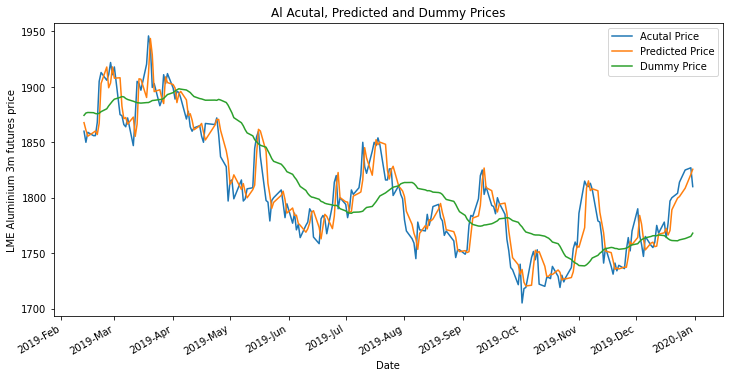

In [25]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str)

plotter.single_plot()

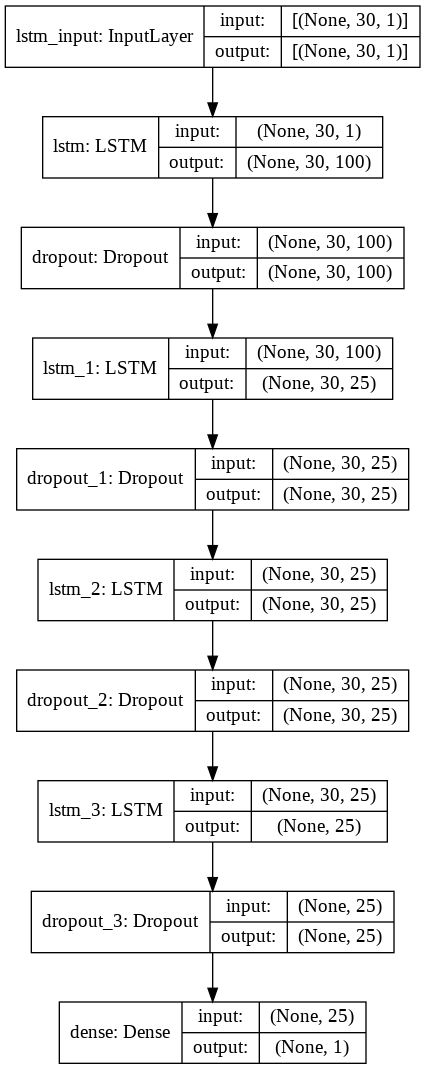

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [26]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  0.004005142369004097
RMSE:  0.06328619414219895
MAE:  0.04963873657946132


In [27]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE:'+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n')
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_Al/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_Al/assets
